*This post is my first foray into plotting geospatial data. I have no prior experience whatsoever, so there may be mistakes here. If you spot anything that looks wrong, please drop a comment below.*

For a paper we're currently writing I need to plot a map of sub-Saharan Africa with colours to indicate something about the type of ecosystem or land-cover. I found [this map of standardized terrestrial ecosystems](http://www.aag.org/cs/publications/special/map_african_ecosystems) for which the underlying data are freely available and can be [downloaded from the USGS website](http://rmgsc.cr.usgs.gov/outgoing/ecosystems/AfricaData/). I need to overlay some points and other graphics on this map, and so I'd like to plot the data using matplotlib.

I've downloaded the data to a local directory and unzipped, here are the file contents:

In [1]:
data_dir = 'data/geo/af_labeled_ecosys'
!ls -lh {data_dir}

total 904M
-rw-rw-r-- 1 aliman aliman   82 Mar 20  2013 Africa_IVC_20130316_final_MG.tfw
-rw-rw-r-- 1 aliman aliman 643M Mar 20  2013 Africa_IVC_20130316_final_MG.tif
-rw-rw-r-- 1 aliman aliman  50K Mar 20  2013 Africa_IVC_20130316_final_MG_tif_arc10_1.lyr
-rw-rw-r-- 1 aliman aliman  49K Apr  2  2013 Africa_IVC_20130316_final_MG_tif_arc10.lyr
-rw-rw-r-- 1 aliman aliman 2.8K Oct  3 17:09 Africa_IVC_20130316_final_MG.tif.aux.xml
-rw-rw-r-- 1 aliman aliman 260M Apr  2  2013 Africa_IVC_20130316_final_MG.tif.ovr
-rw-rw-r-- 1 aliman aliman  45K Oct  4 14:40 Africa_IVC_20130316_final_MG.tif.vat.csv
-rw-rw-r-- 1 aliman aliman 393K Mar 20  2013 Africa_IVC_20130316_final_MG.tif.vat.dbf
-rw-rw-r-- 1 aliman aliman 3.1K Mar 27  2013 Africa_IVC_20130316_final_MG.tif.xml
-rw-rw-r-- 1 aliman aliman 9.1K Mar 27  2013 Africa_IVC_20130316_final_MG.xml
-rw-rw-r-- 1 aliman aliman  69K Mar 23  2013 African and Malagasy Veg_Macrogroups_2013.xlsx


## Inspect the GeoTIFF file

The main data are contained in the file `Africa_IVC_20130316_final_MG.tif` which is a [GeoTIFF file](https://en.wikipedia.org/wiki/GeoTIFF) containing raster data. To read a GeoTIFF file we can use [GDAL](http://www.gdal.org/).

In [2]:
# conda install -c conda-forge gdal
from osgeo import osr, gdal
print('gdal', gdal.__version__)

gdal 2.1.1


In [3]:
# open the dataset
import os
dataset = gdal.Open(os.path.join(data_dir, 'Africa_IVC_20130316_final_MG.tif'))

The first thing to do is figure out what [spatial reference system](https://en.wikipedia.org/wiki/Spatial_reference_system) (a.k.a. coordinate reference system) has been used.

In [4]:
proj_wkt = dataset.GetProjection()
print(proj_wkt)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


The `proj_wkt` variable above is a string formatted according to the [well-known text (WKT)](https://en.wikipedia.org/wiki/Well-known_text) markup language. We can convert this to a spatial reference object.

In [5]:
proj = osr.SpatialReference()
proj.ImportFromWkt(proj_wkt)
print(proj)

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


Here "GEOGCS" stands for "geographic coordinate system", where positions are measured in longitude and latitude relative to a [geodetic datum](https://en.wikipedia.org/wiki/Geodetic_datum), which roughly speaking is a definition of the shape of the Earth. 

Note that this is **not** a projected coordinate system. There is some nice [documentation on geographic and projected coordinate systems](http://www.gdal.org/osr_tutorial.html) on the GDAL website.

The next thing to do is figure out where the boundaries of this image are.

In [6]:
geo_transform = dataset.GetGeoTransform()
geo_transform

(-26.00013888888887,
 0.0008333333333,
 0.0,
 38.00013888888887,
 0.0,
 -0.0008333333332999999)

These numbers define how to transform from pixel raster space to coordinate space. From the [GDAL documentation](http://www.gdal.org/classGDALDataset.html) and [this helpful blog post by Max König](http://geoinformaticstutorial.blogspot.co.uk/2012/09/reading-raster-data-with-python-and-gdal.html), if `geo_transform[2]` and `geo_transform[4]` are zero then the image is "north up". Then `geo_transform[1]` is the pixel width, `geo_transform[5]` is the pixel height, and the upper left corner of the upper left pixel is at position `(geo_transform[0], geo_transform[3])`.

In [7]:
origin_x = geo_transform[0]
origin_y = geo_transform[3]
pixel_width = geo_transform[1]
pixel_height = geo_transform[5]

Get some information about the raster data.

In [8]:
# how big?
n_cols = dataset.RasterXSize
n_rows = dataset.RasterYSize
n_cols, n_rows

(108000, 87600)

In [9]:
# how many bands?
dataset.RasterCount

1

In [10]:
band = dataset.GetRasterBand(1)

In [11]:
# what data type?
gdal.GetDataTypeName(band.DataType)

'Int32'

So the dataset contains a single band of integers. This makes sense as the data are a classification of ecosystems, and so each integer corresponds to an ecosystem class.

The dataset is also big, too large to fit in memory.

In [12]:
import humanize
humanize.naturalsize(n_cols * n_rows * 4)

'37.8 GB'

Here's a few useful things to know about the band, thanks to the [Python GDAL/OGR Cookbook](https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#get-raster-band-information).

In [13]:
band.GetNoDataValue()

-2147483648.0

In [14]:
band.GetMinimum()

0.0

In [15]:
band.GetMaximum()

971.0

In [16]:
band.GetColorTable() is None  # sadly

True

## Extract the colour table

Before we can do anything exciting like actually plotting data, we need to extract the colour table that maps the integer codes onto colours. This has been provided by USGS as a `.dbf` (DBase) file, which I'll convert to text for further processing (thanks to [pvanb for hints](https://pvanb.wordpress.com/2014/02/05/creating-a-qgis-color-map-from-text-file/) on how to handle this). Prepare for some munging.

In [17]:
# apt-get install dbview
!dbview {data_dir}/Africa_IVC_20130316_final_MG.tif.vat.dbf --browse --trim --description > \
    {data_dir}/Africa_IVC_20130316_final_MG.tif.vat.csv

In [18]:
!head -n23 {data_dir}/Africa_IVC_20130316_final_MG.tif.vat.csv

Field Name	Type	Length	Decimal Pos
Value     	  N	    9	    0
Count     	  F	   19	   11
hierarchy 	  C	  254	    0
class     	  C	  254	    0
subclass  	  C	  254	    0
formation 	  C	  254	    0
formation 	  C	  254	    0
division k	  C	  254	    0
division c	  C	  254	    0
Division  	  C	  254	    0
Mgkey     	  C	  254	    0
Mg code   	  C	  254	    0
Mg name fi	  C	  254	    0
Macrogroup	  C	  254	    0
Mapped    	  N	    4	    0
Red       	  F	   13	   11
Green     	  F	   13	   11
Blue      	  F	   13	   11
Opacity   	  F	   13	   11
0:2.73051336800e+009:::::::::::::0:0.00000e+000:0.00000e+000:0.00000e+000:1.00000e+000:
1:3.36479726000e+008:1.A.2.Fd:1 Forest to Open Woodland:1.A Tropical Forest:1.A.2:1.A.2 Tropical Lowland Humid Forest:D147:1.A.2.Fd:1.A.2.Fd Guineo-Congolian Evergreen & Semi-Evergreen Rainforest:MA001:1.A.2.Fd.1:1.A.2.Fd.1-Guineo-Congolian Evergreen Rainforest:Guineo-Congolian Evergreen Rainforest:1:0.00000e+000:4.58824e-001:3.92157e-002:1.00000e+000:
3:3.99018

In [19]:
# extract the field names
import petl as etl
vat_fn = os.path.join(data_dir, 'Africa_IVC_20130316_final_MG.tif.vat.csv')
tbl_descr = etl.fromtsv(vat_fn).head(19).convertall('strip')
tbl_descr.displayall()

Field Name 
 Type 
 Length 
 Decimal Pos 
 
 
 
 
 Value 
 N 
 9 
 0 
 
 
 Count 
 F 
 19 
 11 
 
 
 hierarchy 
 C 
 254 
 0 
 
 
 class 
 C 
 254 
 0 
 
 
 subclass 
 C 
 254 
 0 
 
 
 formation 
 C 
 254 
 0 
 
 
 formation 
 C 
 254 
 0 
 
 
 division k 
 C 
 254 
 0 
 
 
 division c 
 C 
 254 
 0 
 
 
 Division 
 C 
 254 
 0 
 
 
 Mgkey 
 C 
 254 
 0 
 
 
 Mg code 
 C 
 254 
 0 
 
 
 Mg name fi 
 C 
 254 
 0 
 
 
 Macrogroup 
 C 
 254 
 0 
 
 
 Mapped 
 N 
 4 
 0 
 
 
 Red 
 F 
 13 
 11 
 
 
 Green 
 F 
 13 
 11 
 
 
 Blue 
 F 
 13 
 11 
 
 
 Opacity 
 F 
 13 
 11

In [44]:
# extract the data
hdr_colors = tbl_descr.values('Field Name').list()
tbl_colors = (etl
    .fromcsv(vat_fn, delimiter=':')
    .skip(20)  # skip the field descriptions
    .pushheader(hdr_colors)
    .cat()  # remove empty cells beyond columns
    .convert('Value', int)
    .convert(['Count', 'Red', 'Green', 'Blue', 'Opacity'], float)
)
tbl_colors

+-------+--------------+------------+-----------------------------+-----------------------+-----------+-----------+------------+------------+-------------------------------------------------------------------+---------+--------------+---------------------------------------------------------+----------------------------------------------+--------+-----------+----------+-----------+---------+
| Value | Count        | hierarchy  | class                       | subclass              | formation | formation | division k | division c | Division                                                          | Mgkey   | Mg code      | Mg name fi                                              | Macrogroup                                   | Mapped | Red       | Green    | Blue      | Opacity |
+=======+==============+============+=============================+=======================+===========+===========+============+============+===================================================================+=========+==============+=========================================================+==============================================+========+===========+==========+===========+=========+
|     0 | 2730513368.0 | ''         | ''                          | ''                    | ''        | ''        | ''         | ''         | ''                                                                | ''      | ''           | ''                                                      | ''                                           | '0'    |       0.0 |      0.0 |       0.0 |     1.0 |
+-------+--------------+------------+-----------------------------+-----------------------+-----------+-----------+------------+------------+-------------------------------------------------------------------+---------+--------------+---------------------------------------------------------+----------------------------------------------+--------+-----------+----------+-----------+---------+
|     1 |  336479726.0 | '1.A.2.Fd' | '1 Forest to Open Woodland' | '1.A Tropical Forest' | '1.A.2'   | '1.A.2'   | 'D147'     | '1.A.2.Fd' | '1.A.2.Fd Guineo-Congolian Evergreen & Semi-Evergreen Rainforest' | 'MA001' | '1.A.2.Fd.1' | '1.A.2.Fd.1-Guineo-Congolian Evergreen Rainforest'      | 'Guineo-Congolian Evergreen Rainforest'      | '1'    |       0.0 | 0.458824 | 0.0392157 |     1.0 |
+-------+--------------+------------+-----------------------------+-----------------------+-----------+-----------+------------+------------+-------------------------------------------------------------------+---------+--------------+---------------------------------------------------------+----------------------------------------------+--------+-----------+----------+-----------+---------+
|     3 |   39901826.0 | '1.A.2.Fd' | '1 Forest to Open Woodland' | '1.A Tropical Forest' | '1.A.2'   | '1.A.2'   | 'D147'     | '1.A.2.Fd' | '1.A.2.Fd Guineo-Congolian Evergreen & Semi-Evergreen Rainforest' | 'MA003' | '1.A.2.Fd.3' | '1.A.2.Fd.3-Guineo-Congolian Semi-Deciduous Rainforest' | 'Guineo-Congolian Semi-Deciduous Rainforest' | '1'    | 0.0666667 | 0.482353 | 0.0470588 |     1.0 |
+-------+--------------+------------+-----------------------------+-----------------------+-----------+-----------+------------+------------+-------------------------------------------------------------------+---------+--------------+---------------------------------------------------------+----------------------------------------------+--------+-----------+----------+-----------+---------+
|     4 |    3666429.0 | '1.A.2.Fd' | '1 Forest to Open Woodland' | '1.A Tropical Forest' | '1.A.2'   | '1.A.2'   | 'D147'     | '1.A.2.Fd' | '1.A.2.Fd Guineo-Congolian Evergreen & Semi-Evergreen Rainforest' | 'MA004' | '1.A.2.Fd.4' | '1.A.2.Fd.4-Guineo-Congolian Littoral Rainforest'       | 'Guineo-Congolian Littoral Rainforest'       | '1'    |  0.027451 | 0.431373 | 0.0392157 |     1.0 |
+-------+--------------+------------+-----------------------

Now build a matplotlib colour map.

In [21]:
import numpy as np
max_class = tbl_colors.values('Value').max()
max_class

971

In [22]:
colors = np.zeros((max_class+1, 3), dtype=float)
for i, r, g, b in tbl_colors.cut('Value', 'Red', 'Green', 'Blue').data():
    colors[i] = r, g, b

In [23]:
colors

array([[ 0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.458824 ,  0.0392157],
       [ 0.       ,  0.       ,  0.       ],
       ..., 
       [ 1.       ,  0.882353 ,  0.882353 ],
       [ 0.       ,  0.       ,  0.       ],
       [ 1.       ,  0.921569 ,  0.745098 ]])

In [24]:
# check all numbers processed ok
np.count_nonzero(np.isnan(colors))

0

In [25]:
# fix the zero colour to be white
colors[0] = 1, 1, 1

In [26]:
import matplotlib as mpl
color_map = mpl.colors.ListedColormap(colors)

## Extract raster data

To plot the data I'm going to load from the GeoTIFF file into a numpy array. The size of the raster is too big to load the whole thing into memory, so I need to resample the data. A very nice feature of the GDAL API is the ability to specify the size of the output buffer along with the resampling algorithm at the point of extracting data from the GeoTIFF file.

In [27]:
data = dataset.ReadAsArray(buf_xsize=n_cols//100, buf_ysize=n_rows//100, 
                           resample_alg=gdal.GRIORA_Mode)
data

array([[-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       ..., 
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
        -2147483648, -2147483648]], dtype=int32)

In [28]:
data.shape

(876, 1080)

Before we do any proper plotting with cartopy or basemap, let's just take a quick look at the data to check the color map is correct.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# set all missing data as 0 class
data[data < 0] = 0

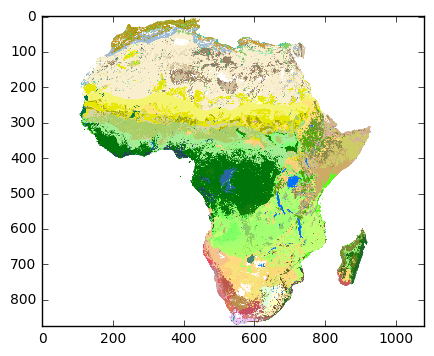

In [31]:
plt.imshow(data, cmap=color_map);

## Plot with `cartopy`

The quick plot above just plots the raster data without any projection onto a coordinate system. For doing this and other useful geospatial plotting things there are two Python libraries, [cartopy](http://scitools.org.uk/cartopy/) and [basemap](http://matplotlib.org/basemap/). Let's look at cartopy first.

In [32]:
# conda install -c conda-forge cartopy
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cartopy 0.14.2


Define the extent of the data. 

In [33]:
extent_lonlat = (
    origin_x, 
    origin_x + (pixel_width * dataset.RasterXSize),
    origin_y + (pixel_height * dataset.RasterYSize),
    origin_y
)

Cartopy needs a projection for plotting. In [this nice example notebook from Filipe Fernandes](https://ocefpaf.github.io/python4oceanographers/blog/2015/03/02/geotiff/) the EPSG code from the projection information given in the GeoTIFF file is used to create a projection via cartopy. However, we cannot do that here because the GeoTIFF we're working with uses a geographical coordinate system and not a projected coordinate system.

In [34]:
print(proj)

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


In this case, the datum is 'WGS84' which is also the default globe that cartopy uses. And because we are using longitude and latitude coordinates, the appropriate projection is the [plate carrée projection](https://en.wikipedia.org/wiki/Equirectangular_projection) which maps meridians to vertical straight lines of constant spacing, and circles of latitude to horizontal straight lines of constant spacing, assuming the standard parallel is the equator. I.e., longitude and latitude become X and Y coordinates.

In [35]:
crs_lonlat = ccrs.PlateCarree()

Now we can plot using this projection, adding in coastlines and country borders.

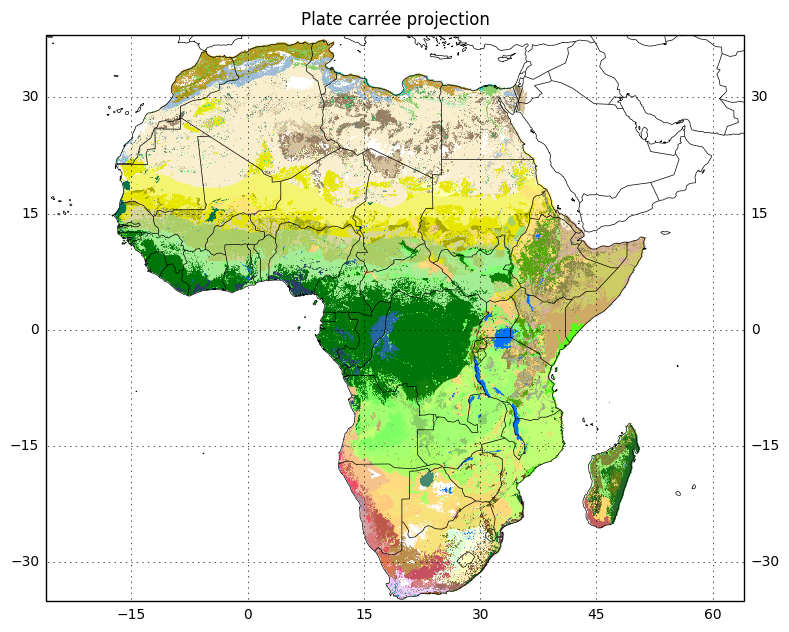

In [36]:
subplot_kw = dict(projection=crs_lonlat)
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=subplot_kw)
ax.set_extent(extent_lonlat, crs=crs_lonlat)
ax.imshow(data, cmap=color_map, extent=extent_lonlat, origin='upper')
ax.coastlines(resolution='50m', linewidth=.5)
gl = ax.gridlines(crs=crs_lonlat, 
                  xlocs=np.arange(-180, 180, 15), 
                  ylocs=np.arange(-180, 180, 15), 
                  draw_labels=True)
gl.xlabels_top = None
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.set_title('Plate carrée projection', va='bottom');

The plate carrée projection distorts both area and shape. [Apparently](http://www.georeference.org/doc/guide_to_selecting_map_projections.htm) [Lambert azimuthal equal area](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) is a better projection for plotting continental Africa, so let's use that.

In [38]:
crs_laea = ccrs.LambertAzimuthalEqualArea()
xmin, ymin = crs_laea.transform_point(extent_lonlat[0], extent_lonlat[2], crs_lonlat)
xmax, ymax = crs_laea.transform_point(extent_lonlat[1], extent_lonlat[3], crs_lonlat)
extent_laea = (xmin, xmax, ymin, ymax)

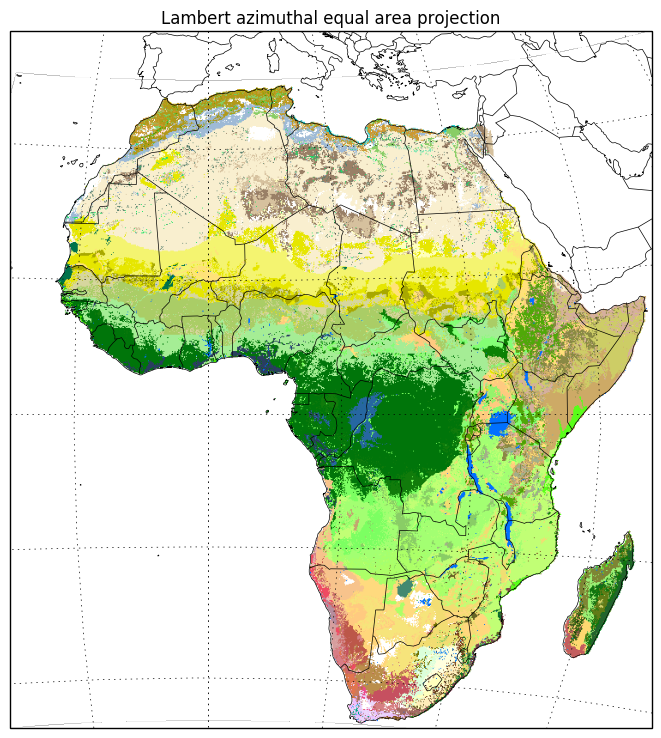

In [40]:
subplot_kw = dict(projection=crs_laea)
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=subplot_kw)
ax.set_extent(extent_laea, crs=crs_laea)
ax.imshow(data, cmap=color_map, extent=extent_lonlat, origin='upper', transform=crs_lonlat)
ax.coastlines(resolution='50m', linewidth=.5)
gl = ax.gridlines(crs=crs_lonlat, 
                  xlocs=np.arange(-180, 180, 15), 
                  ylocs=np.arange(-180, 180, 15))
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.set_title('Lambert azimuthal equal area projection');

This takes a little bit longer to run, I'm guessing because the data are being transformed on the fly.

## Plot with `basemap`

Let's try and do the same thing with basemap.

In [41]:
# conda install -c conda-forge basemap
# conda install -c conda-forge basemap-data-hires
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap; print('basemap', mpl_toolkits.basemap.__version__)

basemap 1.0.8


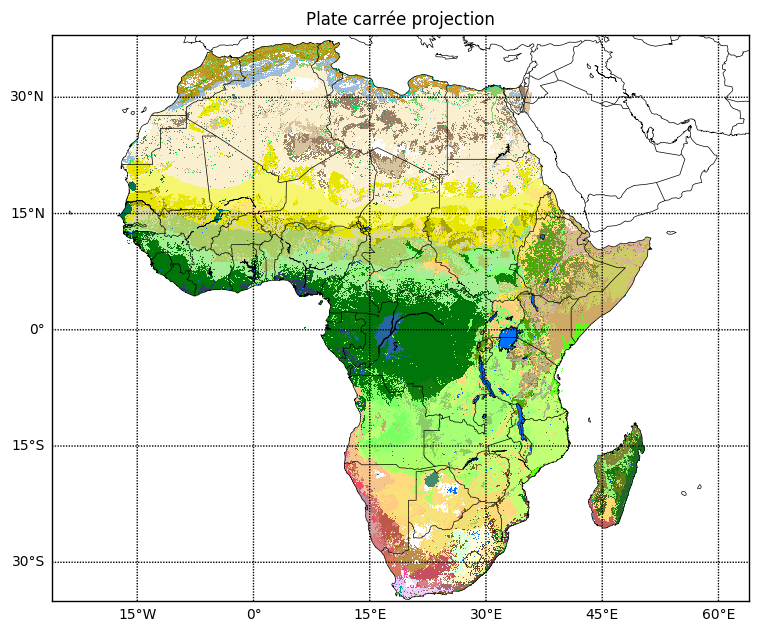

In [42]:
plt.figure(figsize=(9, 9))

# plate carrée projection is known as 'cyl' in basemap
map = Basemap(projection='cyl', resolution='l',
              llcrnrlon=extent_lonlat[0], llcrnrlat=extent_lonlat[2],
              urcrnrlon=extent_lonlat[1], urcrnrlat=extent_lonlat[3])

# plot the raster data
x = np.linspace(extent_lonlat[0], extent_lonlat[1], data.shape[1])
y = np.linspace(extent_lonlat[3], extent_lonlat[2], data.shape[0])
xx, yy = np.meshgrid(x, y)
map.pcolormesh(xx, yy, data, cmap=color_map)

# plot coastlines etc.
map.drawcoastlines(linewidth=.5)
map.drawcountries(linewidth=.5)
parallels = np.arange(-45, 45, 15)
map.drawparallels(parallels, labels=[1, 0, 0, 0])
meridians = np.arange(0, 360, 15)
map.drawmeridians(meridians, labels=[0, 0, 0, 1])
plt.title('Plate carrée projection', va='bottom');

Basemap docs on [managing projections](http://basemaptutorial.readthedocs.io/en/latest/projections.html) and [plotting raster data](http://basemaptutorial.readthedocs.io/en/latest/basic_functions.html#plotting-raster-data) were useful. Note that there is no South Sudan, so for publication images a more up-to-date set of country borders is needed.

Here's the same plot using a different map projection.

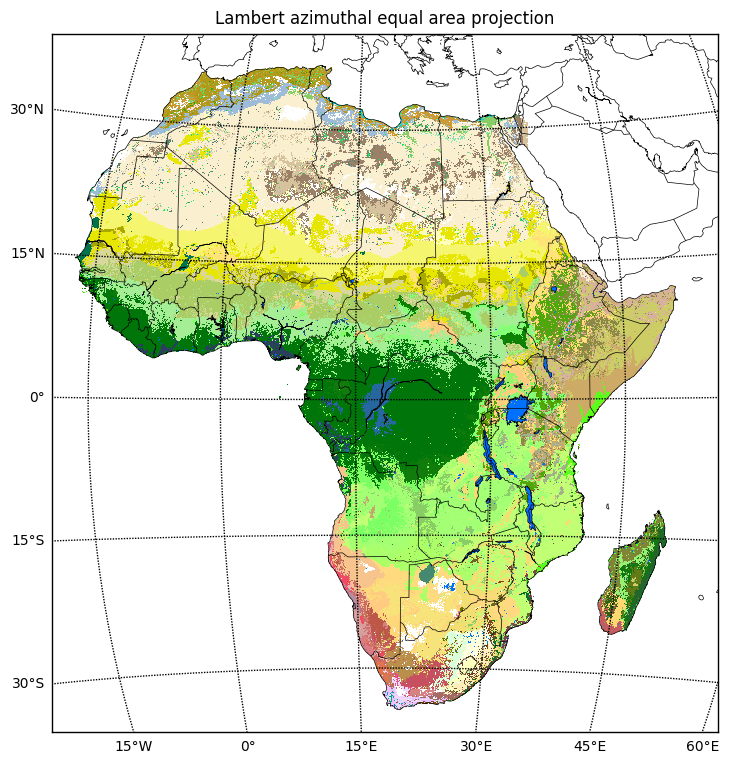

In [43]:
plt.figure(figsize=(9, 9))

# use Lambert azimuthal equal area projection
m = Basemap(projection='laea', resolution='l', 
            lon_0=(extent_lonlat[0] + extent_lonlat[1])/2,
            lat_0=(extent_lonlat[2] + extent_lonlat[3])/2,
            llcrnrlon=extent_lonlat[0], llcrnrlat=extent_lonlat[2],
            urcrnrlon=extent_lonlat[1], urcrnrlat=extent_lonlat[3])

# plot the raster data, transforming coordinates using the map's projection
lons = np.linspace(extent_lonlat[0], extent_lonlat[1], data.shape[1])
lats = np.linspace(extent_lonlat[3], extent_lonlat[2], data.shape[0])
lons, lats = np.meshgrid(lons, lats)
xx, yy = m(lons, lats)
m.pcolormesh(xx, yy, data, cmap=color_map)

# plot coastlines etc.
m.drawcoastlines(linewidth=.5)
m.drawcountries(linewidth=.5)
parallels = np.arange(-45, 45, 15)
m.drawparallels(parallels, labels=[1, 0, 0, 0])
meridians = np.arange(0, 360, 15)
m.drawmeridians(meridians, labels=[0, 0, 0, 1])
plt.title('Lambert azimuthal equal area projection', va='bottom');

Credit to [this SO answer](http://stackoverflow.com/questions/19043846/how-to-correctly-project-a-tif-image-using-matplotlib-basemap) for help on transforming coordinates from lon/lat to the map's projection.

## Further reading

* [USGS global ecosystems](http://rmgsc.cr.usgs.gov/ecosystems/)
* [A New Map of Standardized Terrestrial Ecosystems of Africa](http://www.aag.org/cs/publications/special/map_african_ecosystems)
* [GDAL - Geospatial Data Abstraction Library](http://www.gdal.org/)
* [Python GDAL/OGR Cookbook](https://pcjericks.github.io/py-gdalogr-cookbook/index.html)
* [Cartopy](http://scitools.org.uk/cartopy/)
* [Matplotlib Basemap Toolkit](http://matplotlib.org/basemap/index.html)
* [QGIS](http://www.qgis.com/)
* [Geospatial data with Python](http://nbviewer.jupyter.org/github/mqlaql/geospatial-data/blob/master/Geospatial-Data-with-Python.ipynb) (tutorial from SciPy 2013)
* [Reading Raster Data with Python and gdal](http://geoinformaticstutorial.blogspot.co.uk/2012/09/reading-raster-data-with-python-and-gdal.html) (blog)
* [Plotting geotiff with cartopy](https://ocefpaf.github.io/python4oceanographers/blog/2015/03/02/geotiff/) (blog)
* [Creating a QGIS color map from text file](https://pvanb.wordpress.com/2014/02/05/creating-a-qgis-color-map-from-text-file/) (blog)
